# Landsat Testing Dataset
## [Using Novelty Detection in Keras with Generative Adversarial Network]

This notebook is for test phase Novelty Detection. To Train the model, run this first.
```bash
python models.py
```

It is recommended to understand how the model works in general before continuing the implementation. 

→ [How to do Novelty Detection in Keras with Generative Adversarial Network (Part 1)](https://www.dlology.com/blog/how-to-do-novelty-detection-in-keras-with-generative-adversarial-network/)


In [85]:
from utils import *
from kh_tools import *
import models
import imp
imp.reload(models)
from models import ALOCC_Model
from keras.datasets import mnist

from keras.losses import binary_crossentropy
from keras import backend as K

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
self =ALOCC_Model(dataset_name='mnist', input_height=28,input_width=28)

reconstructor
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z (InputLayer)               (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 4, 4, 8)           0      

## Choose a stopping criterion
The training procedure is stopped when R successfully maps noisy images to clean images carrying the concept of the target class.  When R can reconstruct its input with minimum error. In the following case, we pick the epoch 3.

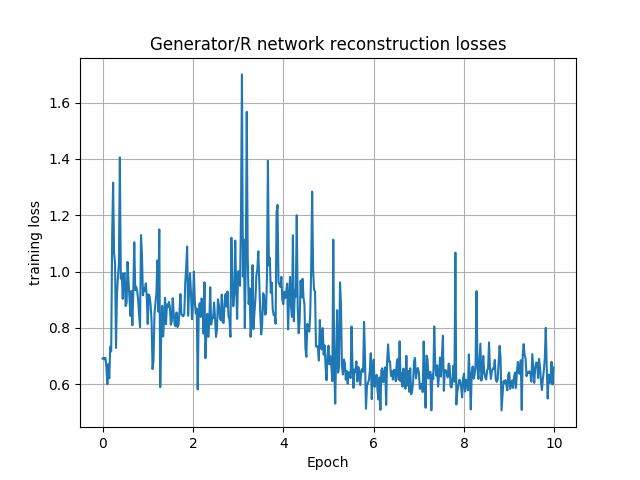

In [88]:
# This image was generated at the end of the models.py training procedure to help pick a ending epoch to load. 
from IPython.display import Image
Image(filename='plot_g_recon_losses.png') 


In [89]:
# Load the epoch #3 saved weights.
self.adversarial_model.load_weights('./checkpoint/ALOCC_Model_9.h5')

In [96]:

#(X_train, y_train), (_, _) = mnist.load_data()
#X_train = X_train / 255

from landsat_data_loader import LandsatDataLoader
root = "/QCOLT/QCOLT_DEV_OPS/"
path = root +'/TDS_NOVELTY_DETECTION/EXP_02//nominal_chips/'    
loader = LandsatDataLoader(path)   
X_train = loader.load_data()
X_train = X_train / 255
#print(X_train.shape)
print("Number of samples loaded =",X_train.shape[0])
print("Dimensions (H,W) = ({},{})".format(X_train.shape[1],X_train.shape[2]))

Number of samples loaded = 9507
Dimensions (H,W) = (28,28)


## Test the reconstruction loss and Discriminator output
The `abnormal` image has a **`larger` reconstruction loss** and **`smaller` discriminator output value**.

In [97]:

def test_reconstruction(index=0, res_edge = 28):
    data = X_train[index].reshape(-1, res_edge, res_edge, 1)[0:1]
        
    model_predicts = self.adversarial_model.predict(data)
    input_image = data[0].reshape((res_edge, res_edge))
    reconstructed_image = model_predicts[0].reshape((res_edge, res_edge))
    
    y_pred = K.variable(reconstructed_image)
    y_true = K.variable(input_image)
    error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    print("Index Image:",index,' Reconstruction loss:', error,'Discriminator Output:', model_predicts[1][0][0])
    #print("Model Predicts:",model_predicts)

    montage = np.hstack((input_image,reconstructed_image))

        
    plt.title('Input Image / Reconstructed')
    plt.imshow(montage, label='Input/Recons')
    #fig.add_subplot(rows, columns, 2)
    #plt.title('Reconstruction')
    #plt.imshow(reconstructed_image, label='Reconstructed')
    plt.show()
   

### Normal case
The network was trained with normal samples.

Index Image: 25  Reconstruction loss: 0.6132394 Discriminator Output: 0.95139545


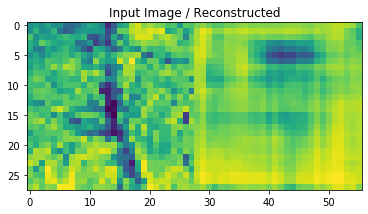

Index Image: 50  Reconstruction loss: 0.69700867 Discriminator Output: 0.7121914


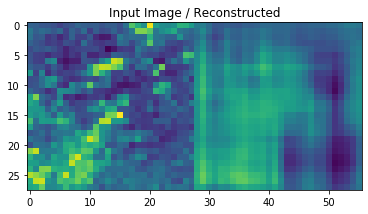

Index Image: 75  Reconstruction loss: 0.6940557 Discriminator Output: 0.99232626


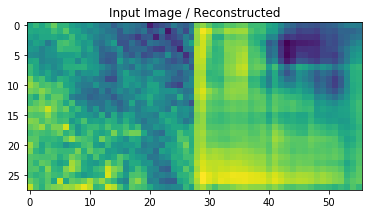

Index Image: 100  Reconstruction loss: 0.68443495 Discriminator Output: 0.3797851


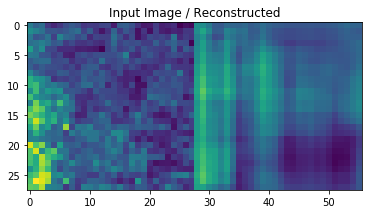

Index Image: 125  Reconstruction loss: 0.7056387 Discriminator Output: 0.7626532


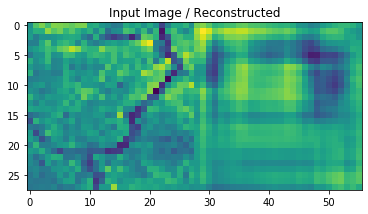

Index Image: 150  Reconstruction loss: 0.68772537 Discriminator Output: 0.22517857


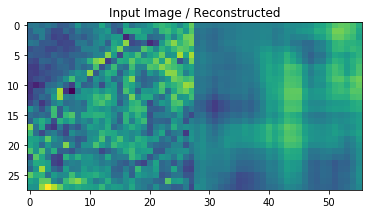

Index Image: 175  Reconstruction loss: 0.66527635 Discriminator Output: 0.25076118


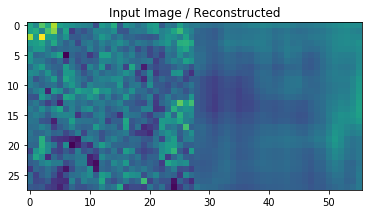

Index Image: 200  Reconstruction loss: 0.6766049 Discriminator Output: 0.24683867


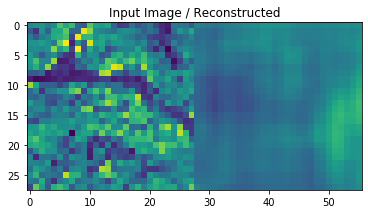

Index Image: 225  Reconstruction loss: 0.6342034 Discriminator Output: 0.25559473


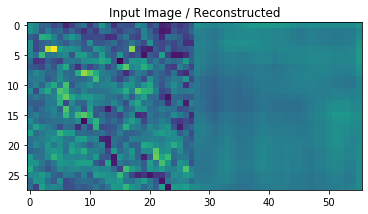

Index Image: 250  Reconstruction loss: 0.67645186 Discriminator Output: 0.042497903


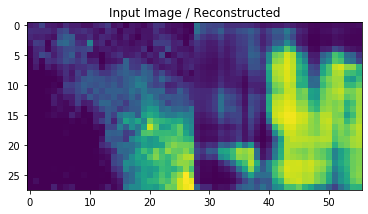

Index Image: 275  Reconstruction loss: 0.6341995 Discriminator Output: 0.23947254


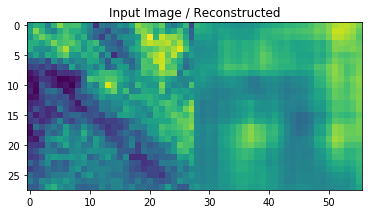

Index Image: 300  Reconstruction loss: 0.7251266 Discriminator Output: 0.1190994


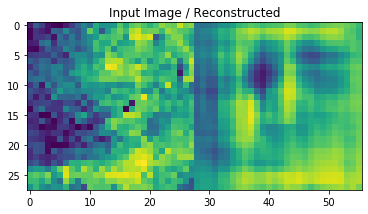

Index Image: 325  Reconstruction loss: 0.71906954 Discriminator Output: 0.70762056


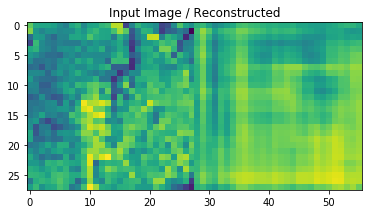

Index Image: 350  Reconstruction loss: 0.7219838 Discriminator Output: 0.94896


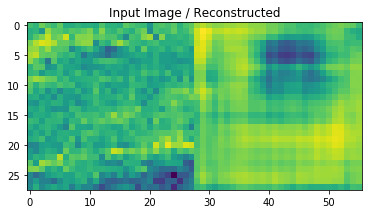

Index Image: 375  Reconstruction loss: 0.7013336 Discriminator Output: 0.8623821


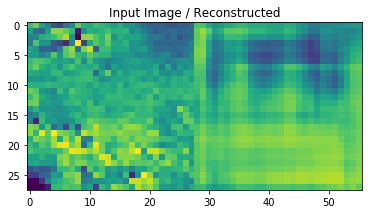

In [ ]:
for i in [25*i for i in range(1,50)]:
    test_reconstruction(i)


## Abnormal cases
The network was not trained on those labels, so the Generator/R network find it hard to reconstruct the input images reflected in higher reconstruction loss values.

Discriminator also outputs a lower value compared to normal ones.

In [ ]:

(X_train, y_train), (_, _) = mnist.load_data()
X_train = X_train / 255

#from landsat_data_loader import LandsatDataLoader
#root = "/QCOLT/QCOLT_DEV_OPS/"
#path = root +'/TDS_NOVELTY_DETECTION/EXP_02//nominal_chips/'    
#loader = LandsatDataLoader(path)   
#X_train = loader.load_data()
#X_train = X_train / 255
#print(X_train.shape)
print("Number of samples loaded =",X_train.shape[0])
print("Dimensions (H,W) = ({},{})".format(X_train.shape[1],X_train.shape[2]))

In [ ]:
def test_reconstruction(index=0, res_edge = 28):
    data = X_train[index].reshape(-1, res_edge, res_edge, 1)[0:1]
        
    model_predicts = self.adversarial_model.predict(data)
    input_image = data[0].reshape((res_edge, res_edge))
    reconstructed_image = model_predicts[0].reshape((res_edge, res_edge))
    
    y_pred = K.variable(reconstructed_image)
    y_true = K.variable(input_image)
    error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    print("Index Image:",index,' Reconstruction loss:', error,'Discriminator Output:', model_predicts[1][0][0])
    #print("Model Predicts:",model_predicts)

    montage = np.hstack((input_image,reconstructed_image))

        
    plt.title('Input Image / Reconstructed')
    plt.imshow(montage, label='Input/Recons')
    #fig.add_subplot(rows, columns, 2)
    #plt.title('Reconstruction')
    #plt.imshow(reconstructed_image, label='Reconstructed')
    plt.show()